## Usage of one explainer

Take EFM and Exp_EFM as an example, and use dataset amazon_toy.

In [1]:
from cornac.datasets import amazon_toy
from cornac.data.reader import Reader
from cornac.eval_methods import StratifiedSplit
from cornac.data.sentiment import SentimentModality
from cornac.models import EFM
from cornac.explainer import Exp_EFM

# Load the Amazon toy dataset
rating = amazon_toy.load_feedback(fmt="UIRT", reader=Reader(min_user_freq=20))
sentiment_data = amazon_toy.load_sentiment(reader=Reader(min_user_freq=20))

md = SentimentModality(data=sentiment_data)

eval_method = StratifiedSplit(
    data=rating,
    group_by="user",
    chrono=True,
    sentiment=md,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
)

# Instantiate the EFM model
efm = EFM(
    max_iter=20,
    num_explicit_factors=128,
    num_latent_factors=128,
    num_most_cared_aspects=100,
    rating_scale=5.0,
    alpha=0.9,
    lambda_x=1,
    lambda_y=1,
    lambda_u=0.01,
    lambda_h=0.01,
    lambda_v=0.01,
    trainable=True,
)
efm.fit(eval_method.train_set)


# Instantiate the explainer
explainer = Exp_EFM(rec_model=efm, dataset=eval_method.train_set)


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 974
Number of items = 7861
Number of ratings = 26231
Max rating = 5.0
Min rating = 1.0
Global mean = 4.3
---
Test data:
Number of users = 974
Number of items = 7861
Number of ratings = 4840
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 974
Total items = 7861


### Explain recommendations

In [2]:
# first, we need some recommendations
some_users = eval_method.test_set.user_ids[:3]
recomedations = efm.recommend_to_multiple_users(some_users, k=5)
print(recomedations)

           user_id     item_id  prediction
0   A2TXMYYGSZCSZ1  B0000524NG    3.703133
1   A2TXMYYGSZCSZ1  B001L123JS    3.586733
2   A2TXMYYGSZCSZ1  B005MQYCY2    3.399667
3   A2TXMYYGSZCSZ1  B005VPREAS    3.397276
4   A2TXMYYGSZCSZ1  B00DH2QY3U    3.351732
5    A2C27IQUH9N1Z  B0000524NG    3.402250
6    A2C27IQUH9N1Z  B001L123JS    3.270584
7    A2C27IQUH9N1Z  B005VPREAS    3.113287
8    A2C27IQUH9N1Z  B005MQYCY2    3.100070
9    A2C27IQUH9N1Z  B000056JLL    3.073330
10   ABSFFH7ECSE49  B0000524NG    3.374592
11   ABSFFH7ECSE49  B001L123JS    3.288109
12   ABSFFH7ECSE49  B005VPREAS    3.107725
13   ABSFFH7ECSE49  B005MQYCY2    3.095141
14   ABSFFH7ECSE49  B004OSQOHW    3.062344


In [3]:
explainer.explain_recommendations(recomedations)

Computing explanations:   0%|          | 0/15 [00:00<?, ?it/s]

,user_id,item_id,prediction,explanations
0,A2TXMYYGSZCSZ1,B0000524NG,3.703133,"{'toy': 5.8406773, 'puzzle': 5.381035, 'really..."
1,A2TXMYYGSZCSZ1,B001L123JS,3.586733,"{'toy': 5.7405624, 'puzzle': 5.2881837, 'reall..."
2,A2TXMYYGSZCSZ1,B005MQYCY2,3.399667,"{'toy': 5.5638375, 'puzzle': 5.361451, 'really..."
3,A2TXMYYGSZCSZ1,B005VPREAS,3.397276,"{'toy': 5.5237722, 'puzzle': 5.2773743, 'reall..."
4,A2TXMYYGSZCSZ1,B00DH2QY3U,3.351732,"{'toy': 5.4370203, 'puzzle': 5.249626, 'really..."
5,A2C27IQUH9N1Z,B0000524NG,3.402250,"{'toy': 5.8406773, 'really': 5.684189, 'game':..."
6,A2C27IQUH9N1Z,B001L123JS,3.270584,"{'toy': 5.7405624, 'really': 5.353897, 'game':..."
7,A2C27IQUH9N1Z,B005VPREAS,3.113287,"{'toy': 5.5237722, 'really': 5.102154, 'game':..."
8,A2C27IQUH9N1Z,B005MQYCY2,3.100070,"{'toy': 5.5638375, 'really': 5.272655, 'game':..."
9,A2C27IQUH9N1Z,B000056JLL,3.073330,"{'toy': 5.3927116, 'really': 5.249818, 'game':..."


### Explain one user-item pair

In [4]:
one_user = eval_method.train_set.user_ids[0]
one_item = eval_method.train_set.item_ids[0]
explanation = explainer.explain_one_recommendation_to_user(one_user, one_item)
print(f"For User {one_user} and Item {one_item}:")
print("Explanation:")
print(explanation)

For User A2TXMYYGSZCSZ1 and Item B00004TZY8:
Explanation:
{'toy': 4.8383207, 'puzzle': 4.698557, 'really': 4.6339245}


### Explain one user-item with ref-item

In [5]:
one_user = eval_method.train_set.user_ids[0]
one_item = eval_method.train_set.item_ids[0]
ref_item = eval_method.train_set.item_ids[10]
explanation = explainer.explain_one_with_ref(user_id=one_user, item_id=one_item, ref_item_id=ref_item)
explanation

,user_id,item_id,explanation,ref_item_id,ref_explanation
0,A2TXMYYGSZCSZ1,B00004TZY8,"{'toy': 4.8383207, 'puzzle': 4.698557, 'really...",B004OS8J98,"{'toy': 4.602877, 'puzzle': 4.267133, 'really'..."


In [6]:
# explanation for user-item
print(explanation['explanation'])
# and explanation for user-ref_item
print(explanation['ref_explanation'])

0    {'toy': 4.8383207, 'puzzle': 4.698557, 'really...
Name: explanation, dtype: object
0    {'toy': 4.602877, 'puzzle': 4.267133, 'really'...
Name: ref_explanation, dtype: object


### Generate plot for Exp_EFM

In [7]:
users = eval_method.test_set.user_ids
recommendations = efm.recommend_to_multiple_users(users, k=10)
explanations = explainer.explain_recommendations(recommendations, feature_k=6)
explanations_df = explanations.copy()

Computing explanations:   0%|          | 0/9740 [00:00<?, ?it/s]

/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/visualization/visualization.py:297: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(x_count, rotation=45)
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/visualization/visualization.py:299: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(x_coeff, rotation=45)


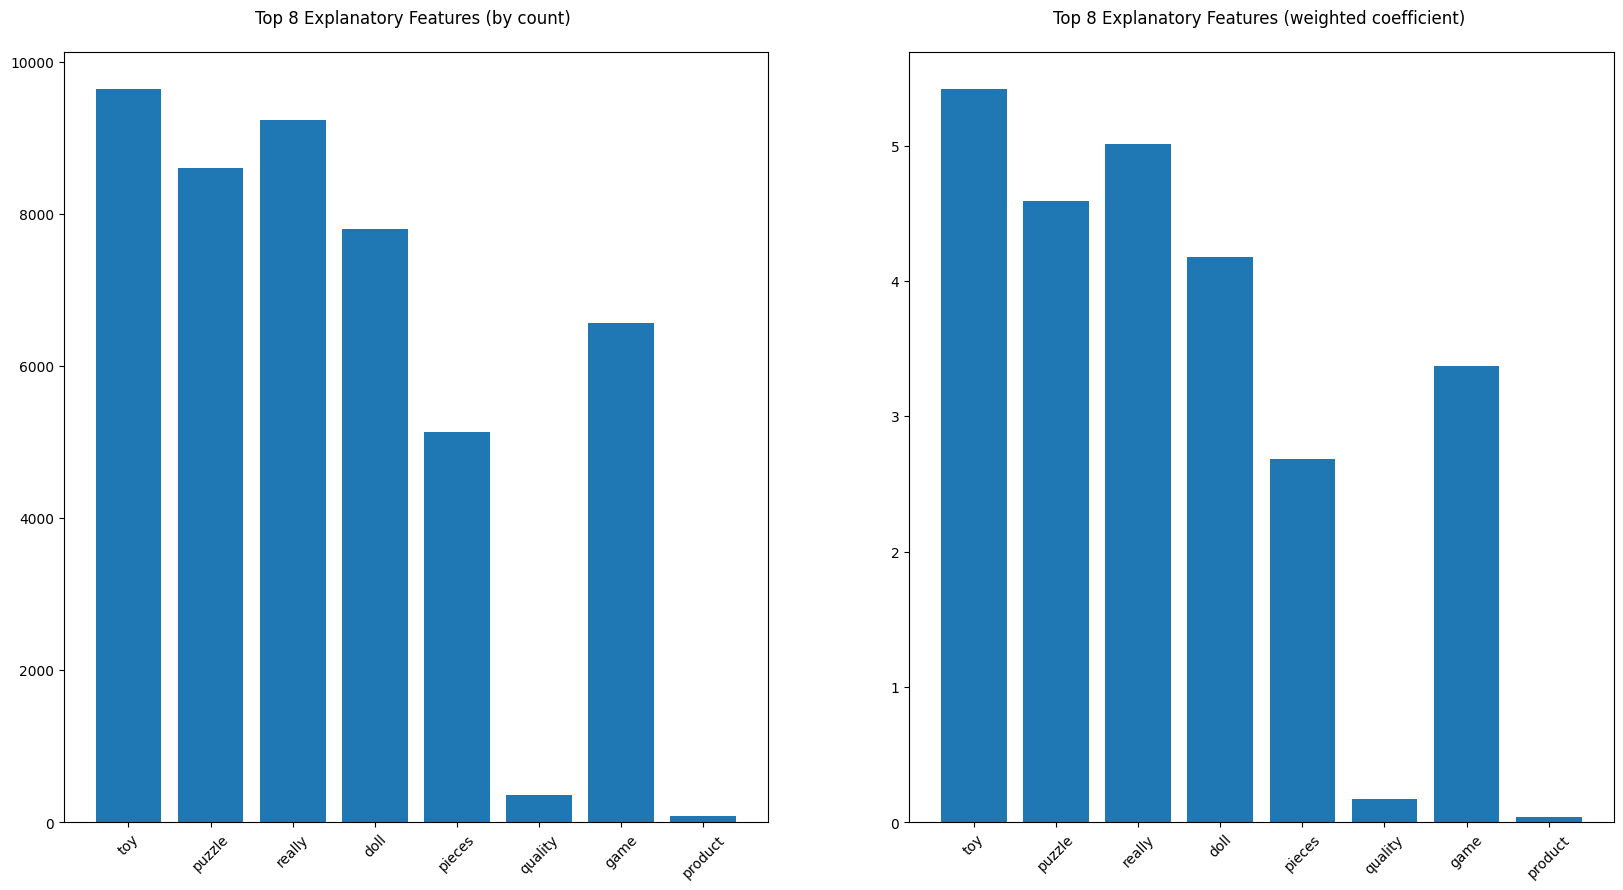

In [8]:
from cornac.visualization import Visualization
my_plots = Visualization()

# Create a plot for a specific user and item
one_user = eval_method.train_set.user_ids[15]
one_item = eval_method.train_set.item_ids[0]
ind_df = my_plots.create_individual_feature_importance_plot(
    explanations,
    user_id=one_user,
    item_id=one_item,
    type="bar",
    top_k=6,
    save_plot=False,
)

filtered_df = my_plots.create_aggregate_feature_importance_plot(
    explanations, type="bar", top_k=8, save_plot=False
)